In [ ]:
## This program uses an artificial recurrent neural network called Long Short Term Memory(LSTM)
# to predict the closing stock price of a corporation (e.g Apple Inc.) using the past 60 day stock price


In [9]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [11]:
import re
import json

def _read_one_data(self, url, params):
    resp = self._get_response(url, params=params)
    if resp.text is None:
        raise ValueError("No data found for symbol {}".format(self.symbols))

    ptrn = r"root\.App\.main = (.*?);\n}\(this\)\;"
    try:
        j = json.loads(re.search(ptrn, resp.text, re.DOTALL).group(1))
        data = j["context"]["dispatcher"]["stores"]["HistoricalPriceStore"]
    except KeyError:
        raise ValueError("No data found for symbol {}".format(self.symbols))

    return data

In [3]:
#Getting stock quote
import pandas_datareader as web

df = web.DataReader('AAPL', data_source ='stooq', start = '2012-01-01', end = '2019-12-17')
df.sort_values(by = ['Date'], inplace = True)
# show the data
df

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,12.4779,12.5577,12.4520,12.5198,3.544907e+08
2012-01-04,12.4849,12.6235,12.4600,12.5866,3.051786e+08
2012-01-05,12.6314,12.7422,12.5627,12.7272,3.178972e+08
2012-01-06,12.7800,12.8717,12.7630,12.8608,3.734286e+08
2012-01-09,12.9525,13.0213,12.8289,12.8408,4.620092e+08
...,...,...,...,...,...
2019-12-11,65.8372,66.3975,65.7604,66.3177,8.053014e+07
2019-12-12,65.5859,66.7544,65.4723,66.4862,1.406056e+08
2019-12-13,66.4862,67.4273,66.3556,67.3914,1.365054e+08


In [4]:
# Get number of rows and columns in data set
df.shape


(2003, 5)

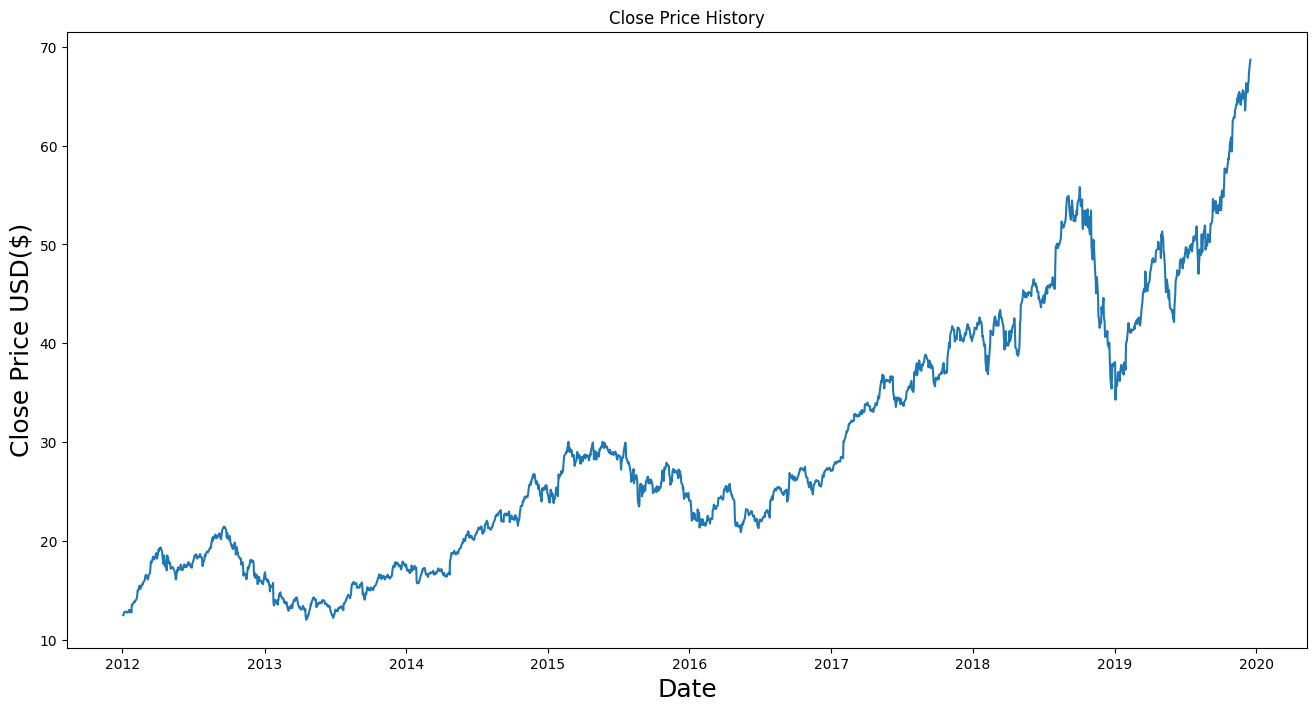

In [5]:
#Visualize the closing price history
import matplotlib.pyplot as plt
plt.figure(figsize = (16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD($)', fontsize =18)
plt.show()

In [6]:
# Create a new dataframe with only the 'Close column
import math
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train LSTM model on 80% of data
training_data_len = math.ceil( len(dataset)  * .8)
training_data_len

1603

In [7]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))  # 0 to 1 inclusive
scaled_data = scaler.fit_transform(dataset)  # computes minimum and maximum value of data set and transforms data based on those two values
scaled_data

array([[0.00804772],
       [0.00922768],
       [0.01171124],
       ...,
       [0.97729999],
       [0.99767542],
       [1.        ]])

In [25]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:training_data_len , :]
#Split the data into x_train and y_train data sets
x_train =[]
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0]) # contain 60 values from  index 0 -5
  y_train.append(train_data[i, 0]) #contain 61st value, index 60
  if i <= 61:
    print(x_train)
    print(y_train)
    print()

[array([0.00804772, 0.00922768, 0.01171124, 0.01407115, 0.01371787,
       0.01452864, 0.01415947, 0.01352356, 0.01266156, 0.01523344,
       0.01764458, 0.01690622, 0.01292652, 0.01672958, 0.01297951,
       0.02708422, 0.02601025, 0.02741984, 0.03048277, 0.03238519,
       0.03222798, 0.03164507, 0.03407563, 0.03640022, 0.03900566,
       0.04323265, 0.05209115, 0.05223247, 0.05718015, 0.06086133,
       0.05453938, 0.05695052, 0.05689753, 0.0637494 , 0.06278141,
       0.06457607, 0.06785275, 0.06966507, 0.07480883, 0.07861189,
       0.07970353, 0.0801098 , 0.07359355, 0.07202498, 0.07227228,
       0.07834693, 0.0801098 , 0.08373622, 0.09241808, 0.10395267,
       0.10178707, 0.10178707, 0.11013331, 0.11275818, 0.11091053,
       0.10918299, 0.10744132, 0.11328634, 0.11733846, 0.11902714])]
[0.1148548990237104]

[array([0.00804772, 0.00922768, 0.01171124, 0.01407115, 0.01371787,
       0.01452864, 0.01415947, 0.01352356, 0.01266156, 0.01523344,
       0.01764458, 0.01690622, 0.012

In [9]:
# Convert the x_train and y_train to numpy arrays to train LTSM model
import numpy as np
x_train = np.array(x_train)
y_train = np.array(y_train)

In [10]:
#Reshape the data

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1543, 60, 1)

In [11]:
#Build LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
#Compile the model
model.compile(optimizer= 'adam', loss = 'mean_squared_error')


In [13]:
#Train model
model.fit(x_train, y_train, batch_size =1, epochs = 1) # batch size is the total number of training examples present in a batch, the number of epochs is the number of iteration when an entire data set is passed forward and bakcward through a neural network


1543/1543 [==============================] - 47s 28ms/step - loss: 8.3955e-04


In [14]:
#Create the testing data set
#Creating a new array containing scaled values from index
test_data = scaled_data[training_data_len-60: , :]
#Creating the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])


In [15]:
# Covert the data into a numpy array
x_test = np.array(x_test)

In [16]:
#Reshape the data
import numpy as np
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [18]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # want predictions to contain same values as y_test dataset

13/13 [==============================] - 1s 15ms/step


In [19]:
# Get the root mean squared error (RMSE), a good meausre of how models predicts a response, a lower value indicates a better fit
rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
rmse

2.55116565766696

<ipython-input-20-bc7b5e834f63>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


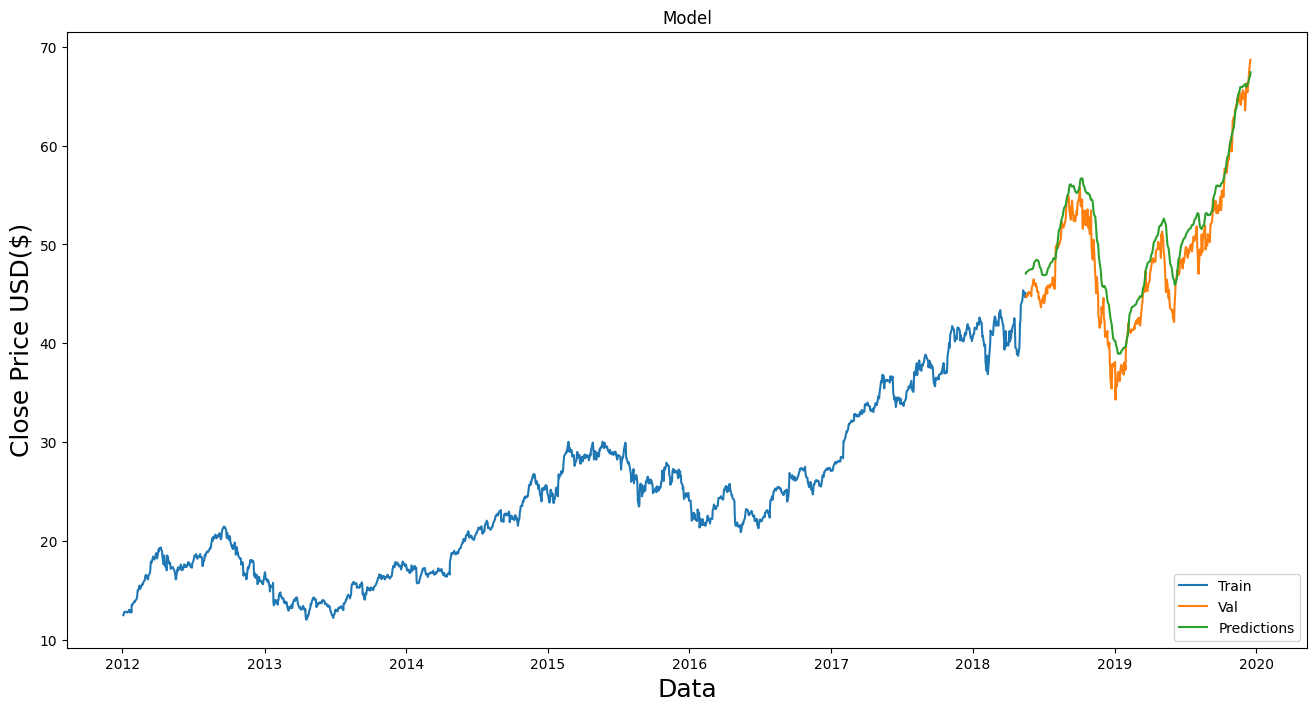

In [20]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#visualize the data
plt.figure(figsize= (16,8))
plt.title('Model')
plt.xlabel('Data', fontsize = 18)
plt.ylabel('Close Price USD($)', fontsize =18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right')
plt.show()

In [21]:
# Show the valid and predicted prices of stock price
valid

,Close,Predictions
Date,,
2018-05-17,44.8054,47.055099
2018-05-18,44.6418,47.188591
2018-05-21,44.9598,47.252476
2018-05-22,44.8482,47.307110
2018-05-23,45.1343,47.338055
...,...,...
2019-12-11,66.3177,66.354858
2019-12-12,66.4862,66.540215
2019-12-13,67.3914,66.741516


In [23]:
# Get the quote
apple_quote = web.DataReader('AAPL', data_source ='stooq', start = '2012-01-01', end = '2019-12-17')
# Create a new data frame
new_df = apple_quote.filter(['Close'])
new_df.sort_values(by = ['Date'], inplace = True)
#Get the last 60 day closing prices values and convert dataframe into an array
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append the past 60 days
X_test.append(last_60_days_scaled)
#Convert x_test data set to a numpy array
X_test = np.array(X_test)
# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)



1/1 [==============================] - 0s 26ms/step
[[67.82783]]


In [24]:
# Get the actual price
apple_quote2 = web.DataReader('AAPL', data_source ='stooq', start = '2019-12-18', end = '2019-12-18')
print(apple_quote2['Close'])


Date
2019-12-18    68.516
Name: Close, dtype: float64
